In [1]:
import os
# os.system('cls')  # On Windows System

from IPython import get_ipython
get_ipython().run_line_magic('reset','-sf')

In [2]:
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler

# plt.close('all')

In [3]:
# import the features and the labels for the training data and the test data
# import the training data
train_dataset = pd.read_csv('train_800.csv',skiprows=1)
val_dataset = pd.read_csv('eval_100.csv', skiprows=1)
test_dataset = pd.read_csv('test_100.csv', skiprows=1)

In [4]:
print(train_dataset.head())

   1233.6186253090575  1549.2746207462244  1  0  793.0457372249411  1.1  0.1  \
0          636.228656         1018.047388  0  0           0.000000    0    0   
1         1404.845637         1593.716730  1  1         891.613793    0    2   
2         1685.802010         1873.436626  0  0         537.673031    0    0   
3         1403.021557         1560.537410  0  0           0.000000    0    0   
4         1628.497747         2230.168744  1  0         793.045737    1    0   

   327.0862956038658  0.2  3      11.45  
0         234.349934    0  4   2.766667  
1         361.056112    4  8  21.116667  
2         373.024338    0  0   3.716667  
3         371.836468    0  9   3.333333  
4         605.064940    1  1   9.950000  


In [5]:

# Dividing each dataset into X (features) and y (taxi_time)
X_train = train_dataset.iloc[:, :10].to_numpy() # First 10 columns for features
y_train = train_dataset.iloc[:, -1].to_numpy() # Last column for target

X_val = val_dataset.iloc[:, :10].to_numpy()
y_val = val_dataset.iloc[:, -1].to_numpy().reshape(-1,1)

X_test = test_dataset.iloc[:, :10].to_numpy()
y_test = test_dataset.iloc[:, -1].to_numpy().reshape(-1,1)

In [6]:
y_test.shape

(100, 1)

In [7]:
#Normalize features (using StandardScalar from SKlearn)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:

# Normalize target (z-normalization) for the y dataset
y_mean = np.mean(y_train)
y_std = np.std(y_train)
y_train_normalized = (y_train - y_mean) / y_std
y_val_normalized = (y_val - y_mean) / y_std
y_test_normalized = (y_test - y_mean) / y_std

#reshape the vectors because it was giving error with (802,) to (802,1)

y_train_normalized = y_train_normalized.reshape(-1,1)
y_val_normalized =  y_val_normalized.reshape(-1,1)
y_test_normalized =  y_test_normalized.reshape(-1,1)


In [9]:
y_test_normalized.shape

(100, 1)

In [10]:
# Define the Leaky ReLU activation function and its derivative
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

In [11]:
def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

In [12]:

# Define the Mean Squared Error loss function and its derivative
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [13]:

def mse_loss_derivative(y_true, y_pred):
    return -(2 / y_true.shape[0]) * (y_true - y_pred)

In [14]:
# Error metrics functions
def error_analysis(y_true, y_pred, epsilon=1e-10): 
   print("RMSE: ", np.sqrt(np.mean((y_true - y_pred) ** 2)))
   print("MSE: ", np.mean((y_true - y_pred) ** 2))
   print("MRE: ", np.mean(np.abs((y_true - y_pred) / (y_true+epsilon))))


In [15]:
len(y_train)

800

In [ ]:
# Initialize the neural network
class NeuralNetwork: 
    def __init__(self, input_size, hlayer1_size, hlayer2_size, output_size, alpha=0.01):
        self.alpha = alpha
        # Initialize weights and biases using HE initialization best for LeakyRelu
        self.weights1 = np.random.randn(input_size, hlayer1_size) * np.sqrt(2/input_size)
        self.biases1 = np.zeros((1, hlayer1_size))
        self.weights2 = np.random.randn(hlayer1_size, hlayer2_size) * np.sqrt(2/hlayer1_size)
        self.biases2 = np.zeros((1, hlayer2_size))
        self.weights3 = np.random.randn(hlayer2_size, output_size) * np.sqrt(2/hlayer2_size)
        self.biases3 = np.zeros((1, output_size))

        # np.sqrt(2 / hlayer1_size)
    
    def forward(self, X):
        # Forward propagation
        self.input = X
        self.hlayer1 = leaky_relu(np.dot(X, self.weights1) + self.biases1, self.alpha)
        self.hlayer2 = leaky_relu(np.dot(self.hlayer1, self.weights2) + self.biases2, self.alpha)
        self.output = np.dot(self.hlayer2, self.weights3) + self.biases3
        return self.output
    
    def valforward(self, X):
        # Forward propagation  
        return np.dot((leaky_relu(np.dot((leaky_relu(np.dot(X, self.weights1) + self.biases1, self.alpha)), self.weights2) + self.biases2, self.alpha)), self.weights3) + self.biases3
        
    def backward(self, X, y, y_pred, lambda_reg=0.001):
        # Backpropagation
        output_error = mse_loss_derivative(y, y_pred)
        output_delta = output_error  # No activation in the output layer since we want it to be continuous
        
        hlayer2_error = np.dot(output_delta, self.weights3.T)
        hlayer2_delta = hlayer2_error * leaky_relu_derivative(self.hlayer2, self.alpha)
        
        hlayer1_error = np.dot(hlayer2_delta, self.weights2.T)
        hlayer1_delta = hlayer1_error * leaky_relu_derivative(self.hlayer1, self.alpha)
         
        # updating the weights -> added regularizationk term after model overfiting
        # Assuming `weights` is a list of weight matrices
        m = len(y)
        
        # l2_term_weight3 = (lambda_reg * sum(self.weights3))/m
        # l2_term_weight2 = (lambda_reg * sum(self.weights2))/m
        # l2_term_weight1 = (lambda_reg * sum(self.weights1))/m



        l2_term_weight3 =  lambda_reg * self.weights3
        l2_term_weight2 = lambda_reg * self.weights2
        l2_term_weight1 = lambda_reg * self.weights1

        # self.weights3 -= (np.dot(self.hlayer2.T, output_delta)) * self.learning_rate
        # self.biases3 -= np.sum(output_delta, axis=0, keepdims=True) * self.learning_rate
        # self.weights2 -= (np.dot(self.hlayer1.T, hlayer2_delta)) * self.learning_rate
        # self.biases2 -= np.sum(hlayer2_delta, axis=0, keepdims=True) * self.learning_rate
        # self.weights1 -= (np.dot(X.T, hlayer1_delta))* self.learning_rate
        # self.biases1 -= np.sum(hlayer1_delta, axis=0, keepdims=True) * self.learning_rate
    
        self.weights3 -= (np.dot(self.hlayer2.T, output_delta) + l2_term_weight3) * self.learning_rate
        self.biases3 -= np.sum(output_delta, axis=0, keepdims=True) * self.learning_rate
        self.weights2 -= (np.dot(self.hlayer1.T, hlayer2_delta) + l2_term_weight2) * self.learning_rate
        self.biases2 -= np.sum(hlayer2_delta, axis=0, keepdims=True) * self.learning_rate
        self.weights1 -= (np.dot(X.T, hlayer1_delta) + l2_term_weight1)* self.learning_rate
        self.biases1 -= np.sum(hlayer1_delta, axis=0, keepdims=True) * self.learning_rate

    def train(self, X, y, iterations, learning_rate, lambda_reg):
        self.learning_rate = learning_rate
        self.lambda_rg = lambda_reg
        train_losses = []
        val_losses = []

        for iter in range(iterations):
            # Forward propagation of training data
            y_pred = self.forward(X)
            # Compute train loss
            train_loss = mse_loss(y, y_pred)

            # #Forward propagation of validation data
            y_valid_pred = self.valforward(X_val)

            y_t_pred = self.valforward(X)
            train1_loss = mse_loss(y, y_t_pred)

            # #compute val loss 
            val_loss = mse_loss(y_val_normalized, y_valid_pred) 

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # Backward propagartion
            self.backward(X, y, y_pred, lambda_reg)

            # loss after every 100 iterations
            if iter % 100 == 0:
                print(f"Training|TrainLoss: {train_loss}|Train1Loss: {train1_loss}|ValidLoss: {val_loss}|Iteration: {iter}")
            
            #save weights after every 100k iterations
            if iter > 0 and iter % 1000 == 0:
                # Get current date in YYYYMMDD format
                current_date = datetime.now().strftime('%Y%m%d%H%M%S') 

                # Create the files to store the weights with date and iteration number
                weights1_file = f'weights2/weights1_{current_date}_{iter}.npy'
                biases1_file = f'weights2/biases1_{current_date}_{iter}.npy'  
                weights2_file = f'weights2/weights2_{current_date}_{iter}.npy'
                biases2_file = f'weights2/biases2_{current_date}_{iter}.npy'   
                weights3_file = f'weights2/weights3_{current_date}_{iter}.npy'
                biases3_file = f'weights2/biases3_{current_date}_{iter}.npy' 
                losses_file = f'weights2/losses_{current_date}_{iter}.npy' 

                #create losses dictionary
                lossesdata = {'train_loss': train_loss, 'valid_loss': val_loss}
 
                np.save(weights1_file, self.weights1)
                np.save(biases1_file, self.biases1)
                np.save(weights2_file, self.weights2)
                np.save(biases2_file, self.biases2)
                np.save(weights3_file, self.weights3)
                np.save(biases3_file, self.biases3)
                np.save(losses_file, lossesdata)

        # showing losses
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()


Training|TrainLoss: 4.262492252748129|Train1Loss: 4.262492252748129|ValidLoss: 3.2039903460043515|Iteration: 0
Training|TrainLoss: 0.49791378107400336|Train1Loss: 0.49791378107400336|ValidLoss: 0.4807620493523084|Iteration: 100
Training|TrainLoss: 0.4640679775244239|Train1Loss: 0.4640679775244239|ValidLoss: 0.46131476775312463|Iteration: 200
Training|TrainLoss: 0.44865309408841625|Train1Loss: 0.44865309408841625|ValidLoss: 0.4583641158618675|Iteration: 300
Training|TrainLoss: 0.439614873558902|Train1Loss: 0.439614873558902|ValidLoss: 0.4557273665989762|Iteration: 400
Training|TrainLoss: 0.4333365614726115|Train1Loss: 0.4333365614726115|ValidLoss: 0.4518717814330393|Iteration: 500
Training|TrainLoss: 0.4284958316609788|Train1Loss: 0.4284958316609788|ValidLoss: 0.448871826947293|Iteration: 600
Training|TrainLoss: 0.42455987691468833|Train1Loss: 0.42455987691468833|ValidLoss: 0.44598360109140456|Iteration: 700
Training|TrainLoss: 0.4212883791986297|Train1Loss: 0.4212883791986297|ValidLoss

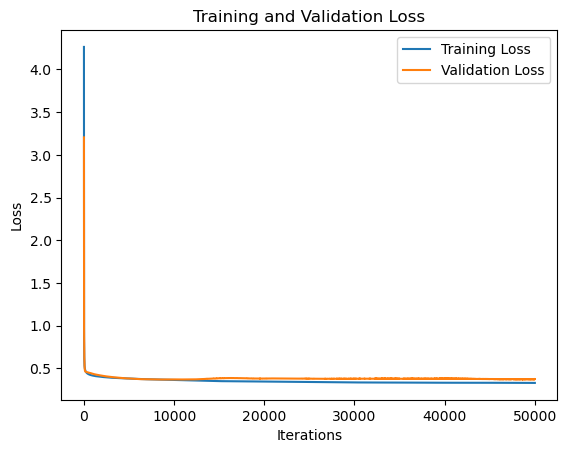

In [48]:

# Initialize the network
nn = NeuralNetwork(10,16,8,1)

# Train the network
nn.train(X_train,y_train_normalized,iterations=50000, learning_rate=0.01, lambda_reg=0.01)


In [49]:


#Evaluation:TRAIN
y_pred_train_normalized = nn.forward(X_train)

#Evaluation:TRAIN => Error metrics for normalized data
print("Normalized Training Data Error Analysis")
error_analysis(y_train_normalized, y_pred_train_normalized)

#Evaluation:TRAIN => Error metrics for raw data
print("Raw Training Data Error Analysis")
#compute raw prediction
y_pred_train = y_pred_train_normalized * y_std + y_mean
error_analysis(y_train, y_pred_train)

#Evaluation:VAL
y_pred_val_normalized = nn.forward(X_val)

#Evaluation:VAL => Error metrics for normalized data
print("Normalized Validation Data Error Analysis")
error_analysis(y_val_normalized, y_pred_val_normalized)

#Evaluation:VAL => Error metrics for raw data
print("Raw validation Data Error Analysis")
#compute raw prediction
y_pred_val = y_pred_val_normalized * y_std + y_mean
error_analysis(y_val, y_pred_val)

#Evaluation:TEST
y_pred_test_normalized = nn.forward(X_test)

#Evaluation:TEST => Error metrics for normalized data
print("Normalized Testing Data Error Analysis")
error_analysis(y_test_normalized, y_pred_test_normalized)

#Evaluation:TEST => Error metrics for raw data
print("Raw Testing Data Error Analysis")
#compute raw prediction
y_pred_test = y_pred_test_normalized * y_std + y_mean
error_analysis(y_test, y_pred_test)

Normalized Training Data Error Analysis
RMSE:  0.5751523398467809
MSE:  0.330800214031227
MRE:  1.2501434971988037
Raw Training Data Error Analysis
RMSE:  5.934693871260008
MSE:  35.22059134557111
MRE:  196861299.0221328
Normalized Validation Data Error Analysis
RMSE:  0.6124917644740447
MSE:  0.37514616154852864
MRE:  2.9144674311693723
Raw validation Data Error Analysis
RMSE:  2.8561135268684454
MSE:  8.15738447836091
MRE:  0.45437618845664535
Normalized Testing Data Error Analysis
RMSE:  0.5420583757208355
MSE:  0.2938272826891104
MRE:  1.7564459995349626
Raw Testing Data Error Analysis
RMSE:  2.5276752260955875
MSE:  6.38914204861738
MRE:  0.4294518566788519
